<a href="https://colab.research.google.com/github/schmuecker/machine-learning-course/blob/main/02%20linear%20regression%20eigengesichtern%20naive%20bayes/02.1%20linear%20regression/02.1_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arbeitsblatt 2: Lineare Regression, Eigengesichter und Bayes-Klassifikator

## 1. Linear Regression on Fish Data

The following data-set contains the number of fish groups of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish caught by a fishing party from the following information: 

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park. 

We have a small data set, of 250 groups, which visited a state park and provided. For comparison the data set is already split into a training set and testset.

In [53]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.stats import poisson
%matplotlib inline

In [54]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')

Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']
print(yte)

df_t = pd.DataFrame(Xt)
df_t.insert(0, 'Intercept',np.ones((200,1)))
print('training set')
print(df_t.describe())

df_te = pd.DataFrame(Xte)
df_te.insert(0, 'Intercept',np.ones((50,1)))
print('test set')
print(df_te.describe())

[ 0.  0.  2.  2.  0.  0.  0.  0.  1.  0.  0.  0.  2.  1.  0.  0.  2.  1.
  0. 30.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.  1.
  1.  3.  6. 65.  0.  0.  0. 16.  0.  0.  6.  0.  9.  0.]
training set
       Intercept           0           1           2           3
count      200.0  200.000000  200.000000  200.000000  200.000000
mean         1.0    0.855000    0.600000    2.540000    0.705000
std          0.0    0.352984    0.491127    1.133501    0.889907
min          1.0    0.000000    0.000000    1.000000    0.000000
25%          1.0    1.000000    0.000000    2.000000    0.000000
50%          1.0    1.000000    1.000000    3.000000    0.000000
75%          1.0    1.000000    1.000000    4.000000    1.000000
max          1.0    1.000000    1.000000    4.000000    3.000000
test set
       Intercept          0          1          2          3
count       50.0  50.000000  50.000000  50.000000  50.000000
mean         1.0   0.900000   0.540000   2.480000   0.600000
std   

In [55]:
pd.DataFrame(yt).describe()

,0
count,200.000000
mean,3.355000
std,11.984872
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,149.000000


a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

In [56]:

y = np.asmatrix(yt)[0].T
X = np.asmatrix(df_t.iloc[:,0:5])
N = y.shape[0] #200
print(X[0:5])
y.shape, X.shape

[[1. 1. 0. 4. 0.]
 [1. 1. 1. 2. 0.]
 [1. 1. 1. 3. 0.]
 [1. 1. 1. 3. 2.]
 [1. 1. 1. 4. 1.]]


((200, 1), (200, 5))

In [57]:
w = np.ones((5)) #Setting w = 1 just for demonstration w is not trained
d = np.matmul(X,w)
d[:,1:10]

matrix([[5., 6., 8., 8., 3., 6., 5., 8., 6.]])

**"By Hand"**

In [58]:
intercepts = np.ones(Xt.shape[0])
X = np.column_stack((intercepts, Xt))

XTX = np.matmul(X.T,X)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, X.T)
w = np.matmul(XTXIXT,y)
w

matrix([[-8.49222821],
        [ 2.4822138 ],
        [ 2.95430727],
        [ 4.64953914],
        [-5.47160051]])

In [59]:
np.mean(np.square((np.matmul(X,w).flatten() - y.flatten()))) # The MSE

117.26947782687193

117.26947782687193

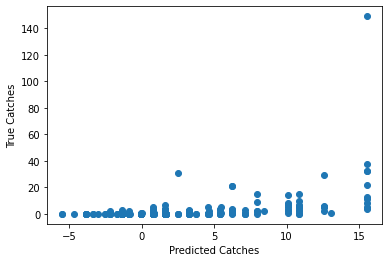

In [60]:
y_pred = np.matmul(X,w)
plt.scatter([y_pred[:,0]], [y[:,0]])
plt.xlabel('Predicted Catches')
plt.ylabel('True Catches')

np.mean(np.square((y_pred[:,0] - y[:,0]))) # The MSE

b) Repeat a) but this time with `LinearRegression` from `sklearn.linear_model`

**Using sklearn**

In [61]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(X,yt) ## Hier hatten wir y statt yt. (Warum erzeugen wir dieses y? mit y kommt obwohl die werte scheinbar gleich sind mit Bene seinem Code etwas falsches raus...)
w = model_skl.coef_
w

array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])

Result: array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])
Don't forget the intercept, you should have 5 numbers!

c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. Estimate $\sigma^2$ using the variance of the residuals. Use the variance estimation with $1/N$. 

Result: $ RMSE \approx 8.58812$, $\hat \sigma^2 \approx 73.7559$, $\tt{NLL} \approx 3.569$

In [62]:
from scipy.stats import norm
pd_Xte = pd.DataFrame(Xte)
pd_Xte.insert(0, 'Intercept',np.ones((50,1)))
X_te = np.asmatrix(pd_Xte)

yh = np.matmul(X_te,coefs.T)
RMSE = np.sqrt(np.mean(np.square((yh[0,:] - yte))))# The RMSE

print('RMSE', RMSE)

sigma2 = (yh[0,:]-yte).var()
print('MSE', sigma2)

gaussian = norm.pdf(yh[0,:]-yte, loc=(yh[0,:]-yte).mean(), scale=np.sqrt(sigma2))
nll = -np.log(gaussian)

print('NLL', nll.mean())

RMSE 8.588126386734233
MSE 73.4803035991981
NLL 3.5674472292366746


d) For the testset: plot the predicted mean number of fish caught ($\mu$) against observed number of fish caught. Further include the 2.5 and 97.5 precentile of p(y|x), the conditional predictive distribution (CPD) of $y$ for a given $x$. Why is a Gaussian not ideal for that kind of data? 

Hint: For the Gaussian the 2.5% and the 97.5% percentile is approximatiy given by $\mu \pm 1.96*\sigma$

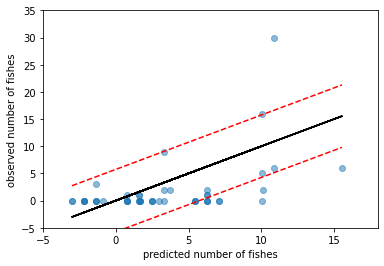

In [63]:
y_pred = np.array([np.dot(w[1:].T, x_i) + w[0] for x_i in Xte])
plt.scatter(y_pred, yte,alpha=0.5)
sort_idx = np.argsort(y_pred,axis=0)
plt.plot(y_pred[sort_idx].flatten(), y_pred[sort_idx].flatten()+1.96*np.sqrt(RMSE), linestyle='dashed', c="red")
plt.plot(y_pred[sort_idx].flatten(), y_pred[sort_idx].flatten()-1.96*np.sqrt(RMSE), linestyle='dashed', c="red")
plt.plot(y_pred, y_pred, c="black")

plt.xlabel('predicted number of fishes')
plt.ylabel('observed number of fishes')
plt.xlim(-5,18)
plt.ylim(-5,35)
plt.show()

e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal. 

Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 log(p(k)) = -\mu  + k \cdot \log(\mu) - log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$ by minimizing the NLL. 

A small additional detail: For the Poissonian case, $\mu_i$ needs to be positive. We therefore do not use $\beta^T \cdot x_i$ directly but "pipe it through" an exponential first to make it positive and thus link $\mu_i=exp(\beta^T \cdot x_i)$ to the data.

Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).

Hint: On the trainingset for the parameter values (1,1,1,1,1) the NLL should be approx 1508 and the gradient (1518.61, 1403.99, 1171.02, 5701.91, 3258.7). For the NLL a good learning rate would be 0.001 and training should be done for at least 5000 epochs.

In [64]:
def negative_log_likelihood(yt, Xt, w):
    mu = np.exp(np.matmul(Xt,w))
    NLL = np.zeros_like(mu)
    for i in range(NLL.shape[0]):
        NLL[i] = mu[i] - yt[i]*np.log(mu[i]) + np.log(1.0*np.math.factorial(int(yt[i])))
    return np.mean(NLL), mu
    
def gradient_descent_NLL(yt, Xt, w):
    mu = np.exp(np.matmul(Xt,w))
    theta = np.zeros_like(Xt)
    for i in range(Xt.shape[0]):
        mux = Xt[i] * mu[i]
        theta[i] = -mux + yt[i] * Xt[i]
    return np.mean(theta, axis=0)

In [65]:
# initalize the weights
w = np.ones(5)

# calculate the NLL
mean, mu = negative_log_likelihood(yt, X, w)
print("NLL:", np.round(mean))

# Brechenung der Gradienten 
print("Gradients:", np.abs(np.round(gradient_descent_NLL(yt, X, w),2)))

NLL: 1508.0
Gradients: [1518.61 1403.99 1171.02 5701.91 3258.7 ]


In [66]:
hist = []
epochs = 5000
learning_rate = 0.001

# initalize the weights
w = np.ones(5)

for i in tqdm(range(epochs)):
    mean, mu = negative_log_likelihood(yt, X, w)
    hist.append(mean)
    w = w + learning_rate * gradient_descent_NLL(yt, X, w)

print('\n', w)

100%|██████████| 5000/5000 [00:14<00:00, 354.82it/s]


 [-1.08852056  0.2597268   0.54509109  0.85448041 -1.65101241]


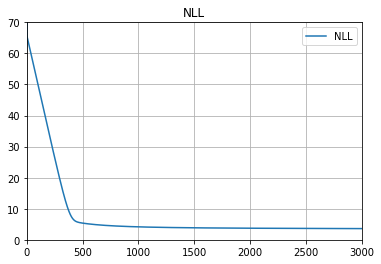

In [67]:
plt.plot(hist)
plt.grid()
plt.legend(["NLL"])
plt.title("NLL")
plt.ylim(0,70)
plt.xlim(0,3000)
plt.show()

f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.

In [68]:
intercepts = np.ones(Xte.shape[0])
Xte = np.column_stack((intercepts, Xte))
y_pred = np.exp(np.matmul(Xte, w))

In [69]:
mean, mu = negative_log_likelihood(yt, X, w)
sort_idx = np.argsort(mu,axis=0)
mu = mu[sort_idx].flatten()
perc1 = poisson.ppf(0.025, mu)
perc2 = poisson.ppf(0.975, mu)

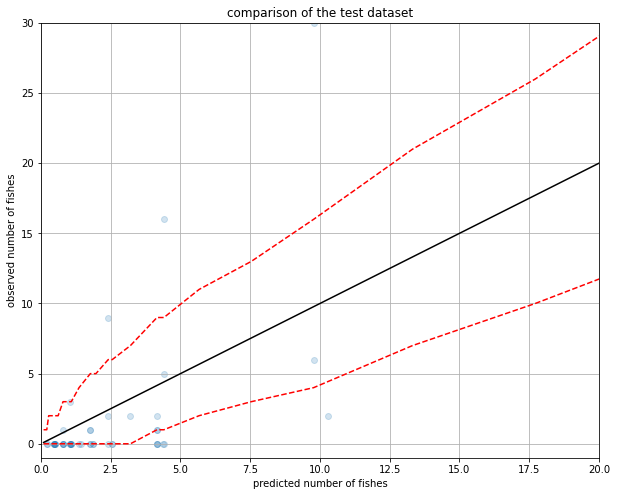

In [74]:
plt.figure(figsize=(10,8))
plt.scatter(y_pred, yte,alpha=0.2)
sort_idx = np.argsort(y_pred,axis=0)
plt.plot(mu, perc1, linestyle='dashed', c="red")
plt.plot(mu, perc2, linestyle='dashed', c="red")
plt.plot(mu, mu, c="black")
plt.title('comparison of the test dataset')
plt.xlabel('predicted number of fishes')
plt.ylabel('observed number of fishes')
plt.grid()
plt.xlim(0,20)
plt.ylim(-1,30)
plt.show()